# Actinia Demo

In [48]:
# Import Python standard library and IPython packages we need.
import os
import subprocess
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint
import json
import time
import requests
from requests.auth import HTTPBasicAuth

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
os.environ["ACTINIA_USER"] = 'actinia-gdi'
os.environ["ACTINIA_PASSWORD"] = 'actinia-gdi'
os.environ["AUTH"] = 'actinia-gdi:actinia-gdi'
os.environ["ACTINIA_URL"] = 'http://localhost:8088'

ACTINIA_VERSION = 'v3'
ACTINIA_BASEURL = 'http://localhost:8088'
ACTINIA_URL = ACTINIA_BASEURL + "/api/" + ACTINIA_VERSION
ACTINIA_AUTH = HTTPBasicAuth("actinia-gdi", "actinia-gdi")
sys.path.append(os.path.join(gisbase, "etc", "python"))

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
## Set your grass data location
gj.init("../actinia-core-data/grassdb", "nc_spm_08", "PERMANENT")

In [ ]:
def print_as_json(data):
    print(json.dumps(data, indent=2))

In [49]:
gs.parse_command("g.list", type="raster")

{'aspect': None,
 'basin_50K': None,
 'boundary_county_500m': None,
 'cfactorbare_1m': None,
 'cfactorgrow_1m': None,
 'el_D782_6m': None,
 'el_D783_6m': None,
 'el_D792_6m': None,
 'el_D793_6m': None,
 'elev_lid792_1m': None,
 'elev_ned_30m': None,
 'elev_srtm_30m': None,
 'elev_state_500m': None,
 'elevation': None,
 'elevation_shade': None,
 'facility': None,
 'geology_30m': None,
 'lakes': None,
 'landclass96': None,
 'landcover_1m': None,
 'landuse96_28m': None,
 'lsat7_2002_10': None,
 'lsat7_2002_20': None,
 'lsat7_2002_30': None,
 'lsat7_2002_40': None,
 'lsat7_2002_50': None,
 'lsat7_2002_61': None,
 'lsat7_2002_62': None,
 'lsat7_2002_70': None,
 'lsat7_2002_80': None,
 'ncmask_500m': None,
 'ortho_2001_t792_1m': None,
 'roadsmajor': None,
 'slope': None,
 'soilsID': None,
 'soils_Kfactor': None,
 'streams_derived': None,
 'towns': None,
 'urban': None,
 'zipcodes': None,
 'zipcodes_dbl': None}

## Actinia Extension

In [ ]:
# actinia importer installation
!g.extension extension=importer url=https://github.com/mundialis/importer

# actinia exporter installation
!g.extension extension=exporter url=https://github.com/mundialis/exporter

# ace (actinia command execution) tool
!g.extension extension=ace url=https://github.com/mundialis/ace

## List GRASS Locations User has Access to

### ace

In [50]:
!ace -l

['nc_spm_08', 'latlong_wgs84', 'utm32n']


### api

In [52]:
!curl -u 'actinia-gdi:actinia-gdi' -X GET -i "http://localhost:8088/api/v3/locations" 

HTTP/1.1 200 OK
Server: gunicorn/20.0.4
Date: Tue, 22 Mar 2022 19:40:59 GMT
Connection: keep-alive
Content-Type: application/json
Content-Length: 72
Access-Control-Allow-Origin: *

{"locations":["nc_spm_08","latlong_wgs84","utm32n"],"status":"success"}


## List Mapsets User has Access to in Location

In [53]:
!ace location="nc_spm_08" -m 

['PERMANENT', 'landsat', 'test', 'user1']


## Create Mapset

In [54]:
!ace location="nc_spm_08" create_mapset="test_ms"

Trying to create mapset test_ms
{'accept_datetime': '2022-03-22 19:41:59.416692',
 'accept_timestamp': 1647978119.4166865,
 'api_info': {'endpoint': 'mapsetmanagementresourceadmin',
              'method': 'POST',
              'path': '/api/v3/locations/nc_spm_08/mapsets/test_ms',
              'request_url': 'http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/test_ms'},
 'datetime': '2022-03-22 19:41:59.602279',
 'http_code': 200,
 'message': 'Mapset <test_ms> successfully created.',
 'process_chain_list': [{'1': {'flags': 'l', 'module': 'g.mapsets'}}],
 'process_log': [{'executable': 'g.mapsets',
                  'id': '1',
                  'parameter': ['-l'],
                  'return_code': 0,
                  'run_time': 0.05016827583312988,
                  'stderr': ['Available mapsets:', ''],
                  'stdout': 'PERMANENT landsat test user1\n'}],
 'process_results': {},
 'progress': {'num_of_steps': 1, 'step': 1},
 'resource_id': 'resource_id-49e74d2a-d90f-

In [55]:
!ace location="nc_spm_08" -m

['PERMANENT', 'landsat', 'test', 'test_ms', 'user1']


To list all raster maps available in the specified mapset belonging to the provided location nc_spm_08, run:

In [56]:
!ace location="nc_spm_08" mapset="test_ms" -r

[]


In [57]:
!ace location="nc_spm_08" mapset="PERMANENT" -r

['aspect',
 'basin_50K',
 'boundary_county_500m',
 'cfactorbare_1m',
 'cfactorgrow_1m',
 'el_D782_6m',
 'el_D783_6m',
 'el_D792_6m',
 'el_D793_6m',
 'elev_lid792_1m',
 'elev_ned_30m',
 'elev_srtm_30m',
 'elev_state_500m',
 'elevation',
 'elevation_shade',
 'facility',
 'geology_30m',
 'lakes',
 'landclass96',
 'landcover_1m',
 'landuse96_28m',
 'lsat7_2002_10',
 'lsat7_2002_20',
 'lsat7_2002_30',
 'lsat7_2002_40',
 'lsat7_2002_50',
 'lsat7_2002_61',
 'lsat7_2002_62',
 'lsat7_2002_70',
 'lsat7_2002_80',
 'ncmask_500m',
 'ortho_2001_t792_1m',
 'roadsmajor',
 'slope',
 'soilsID',
 'soils_Kfactor',
 'streams_derived',
 'towns',
 'urban',
 'zipcodes',
 'zipcodes_dbl']


In [58]:
!ace location="nc_spm_08" mapset="PERMANENT" -v

['P079214',
 'P079215',
 'P079218',
 'P079219',
 'boundary_county',
 'boundary_municp',
 'bridges',
 'busroute1',
 'busroute11',
 'busroute6',
 'busroute_a',
 'busroutesall',
 'busstopsall',
 'census_wake2000',
 'censusblk_swwake',
 'comm_colleges',
 'elev_lid792_bepts',
 'elev_lid792_cont1m',
 'elev_lid792_randpts',
 'elev_lidrural_mrpts',
 'elev_lidrural_mrptsft',
 'elev_ned10m_cont10m',
 'firestations',
 'geodetic_pts',
 'geodetic_swwake_pts',
 'geology',
 'geonames_NC',
 'geonames_wake',
 'hospitals',
 'lakes',
 'nc_state',
 'overpasses',
 'poi_names_wake',
 'precip_30ynormals',
 'precip_30ynormals_3d',
 'railroads',
 'roadsmajor',
 'schools_wake',
 'soils_general',
 'soils_wake',
 'streams',
 'streets_wake',
 'swwake_10m',
 'urbanarea',
 'usgsgages',
 'zipcodes_wake']


## List Raster Data

### ace

In [59]:
!ace -d location="nc_spm_08" grass_command="g.list raster" | jq 

{
  "version": "1",
  "list": [
    {
      "module": "g.list",
      "id": "g.list_1804289383",
      "inputs": [
        {
          "param": "type",
          "value": "raster"
        },
        {
          "param": "separator",
          "value": "newline"
        }
      ]
    }
  ]
}


### api

In [60]:
!curl -u 'actinia-gdi:actinia-gdi' -X GET "http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/PERMANENT/raster_layers/" | jq

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2192  100  2192    0     0   4223      0 --:--:-- --:--:-- --:--:--  4215
{
  "accept_datetime": "2022-03-22 19:44:29.847933",
  "accept_timestamp": 1647978269.8479314,
  "api_info": {
    "endpoint": "rasterlayersresource",
    "method": "GET",
    "path": "/api/v3/locations/nc_spm_08/mapsets/PERMANENT/raster_layers/",
    "request_url": "http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/PERMANENT/raster_layers/"
  },
  "datetime": "2022-03-22 19:44:29.914391",
  "http_code": 200,
  "message": "Processing successfully finished",
  "process_chain_list": [
    {
      "1": {
        "inputs": {
          "mapset": "PERMANENT",
          "type": "raster"
        },
        "module": "g.list"
      }
    }
  ],
  "process_log": [
    {
      "executable": "g.list",
      "id": "1",
      "parameter": [
        "mapset=PER

## Request Region

In [61]:
!ace -d location="nc_spm_08" mapset="PERMANENT" grass_command="g.region -p" | jq

{
  "version": "1",
  "list": [
    {
      "module": "g.region",
      "id": "g.region_1804289383",
      "flags": "p"
    }
  ]
}


## Run Commands

### Get r.info

### ace

In [62]:
!ace location="nc_spm_08" grass_command="r.info elevation"

http://localhost:8088/api/v3/locations/nc_spm_08/processing_async_export
{'version': '1', 'list': [{'module': 'r.info', 'id': 'r.info_1804289383', 'inputs': [{'param': 'map', 'value': 'elevation'}]}]}
actinia-gdi
Resource status accepted
Polling: https://localhost:8088/api/v3/resources/actinia-gdi/resource_id-25532440-8fca-465a-b655-365563bba42c
^C
Traceback (most recent call last):
  File "/home/coreywhite/.grass8/addons/scripts/ace", line 775, in <module>
    main()
  File "/home/coreywhite/.grass8/addons/scripts/ace", line 733, in main
    send_poll_commands(commands=[split_grass_command(grass_command), ], mapset=mapset)
  File "/home/coreywhite/.grass8/addons/scripts/ace", line 576, in send_poll_commands
    r = requests.get(poll_url, auth=ACTINIA_AUTH)
  File "/usr/lib/python3/dist-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/usr/lib/python3/dist-packages/requests/api.py", line 61, in request
    return session.request

### api

In [63]:
!curl -u 'actinia-gdi:actinia-gdi' -X GET "http://localhost:8088/api/v3/locations/latlong_wgs84/mapsets/modis_ndvi_global/strds/ndvi_16_5600m/raster_layers" | jq

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2236  100  2236    0     0   4367      0 --:--:-- --:--:-- --:--:--  4367
{
  "accept_datetime": "2022-03-22 19:47:09.356949",
  "accept_timestamp": 1647978429.3569481,
  "api_info": {
    "endpoint": "strdsrastermanagement",
    "method": "GET",
    "path": "/api/v3/locations/latlong_wgs84/mapsets/modis_ndvi_global/strds/ndvi_16_5600m/raster_layers",
    "request_url": "http://localhost:8088/api/v3/locations/latlong_wgs84/mapsets/modis_ndvi_global/strds/ndvi_16_5600m/raster_layers"
  },
  "datetime": "2022-03-22 19:47:09.369598",
  "exception": {
    "message": "AsyncProcessError:  Unable to create a temporary GIS database, Exception: AsyncProcessError:  Unable to link all required mapsets into temporary location. Missing or un-accessible mapset <modis_ndvi_global> in location <latlong_wgs84>",
    "traceback": [
      "  Fi

### r.slope.aspect

In [70]:
!ace location="nc_spm_08" mapset="test" grass_command="r.slope.aspect elevation=elevation slope=myslope" -d | jq

{
  "version": "1",
  "list": [
    {
      "module": "r.slope.aspect",
      "id": "r.slope.aspect_1804289383",
      "inputs": [
        {
          "param": "elevation",
          "value": "elevation"
        },
        {
          "param": "format",
          "value": "degrees"
        },
        {
          "param": "precision",
          "value": "FCELL"
        },
        {
          "param": "zscale",
          "value": "1.0"
        },
        {
          "param": "min_slope",
          "value": "0.0"
        }
      ],
      "outputs": [
        {
          "param": "slope",
          "value": "myslope"
        }
      ]
    }
  ]
}


In [71]:
!ace location="nc_spm_08" mapset="test" grass_command="r.slope.aspect elevation=elevation slope=myslope" | jq

parse error: Invalid numeric literal at line 1, column 5
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/contrib/pyopenssl.py", line 488, in wrap_socket
    cnx.do_handshake()
  File "/usr/lib/python3/dist-packages/OpenSSL/SSL.py", line 1934, in do_handshake
    self._raise_ssl_error(self._ssl, result)
  File "/usr/lib/python3/dist-packages/OpenSSL/SSL.py", line 1664, in _raise_ssl_error
    raise SysCallError(-1, "Unexpected EOF")
OpenSSL.SSL.SysCallError: (-1, 'Unexpected EOF')

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 381, in _make_request
    self._validate_conn(conn)
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 978, in _validate_conn
    conn.connect()
  File 

## View Jobs

In [66]:
!ace list_jobs="all" | grep "2022-03-22"

resource_id-7629e6d0-6c8a-4aff-b612-2faf69bbfed6 finished 2022-03-22 18:47:52.167731
resource_id-e12dff46-c4e0-426a-baaa-a32ed253a3c2 finished 2022-03-22 19:15:34.450742
resource_id-28aea41f-be5a-4853-9e9c-8ab694eac2f8 finished 2022-03-22 19:15:45.223594
resource_id-cb3ffc59-95f1-4f99-b347-b745d2ce4708 finished 2022-03-22 19:31:31.418899
resource_id-5f9493da-3f3f-4f82-a372-c0b4806da722 finished 2022-03-22 18:47:48.005670
resource_id-1a2f2e95-bdf8-4a5c-9081-b51e5c67ac9d finished 2022-03-22 18:47:46.193734
resource_id-68ade748-fba8-4e87-afe9-55a912ec1f42 finished 2022-03-22 14:43:52.265388
resource_id-5301428d-4877-48c4-a835-417abc4c3745 finished 2022-03-22 14:47:59.283375
resource_id-61ef6917-a877-443b-ac5f-be24b2df28bc finished 2022-03-22 19:31:54.445674
resource_id-baa74383-1c55-4ae4-a90a-24ba750fa4f0 finished 2022-03-22 14:46:35.881945
resource_id-c49ad8d8-f776-4130-a7fa-55cfd624ec22 finished 2022-03-22 19:48:30.836561
resource_id-3f4d9b92-6499-4b45-a909-9ba67c184e86 finished 2022-03

In [ ]:
!curl -u 'actinia-gdi:actinia-gdi' -X GET "http://localhost:8088/api/v3/locations/latlong_wgs84/mapsets/modis_ndvi_global/strds/ndvi_16_5600m/raster_layers" | jq

Trying to render raster_layers map elev_state_500m of mapset PERMANENT
http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/PERMANENT/raster_layers/elev_state_500m/render?width=800&height=600


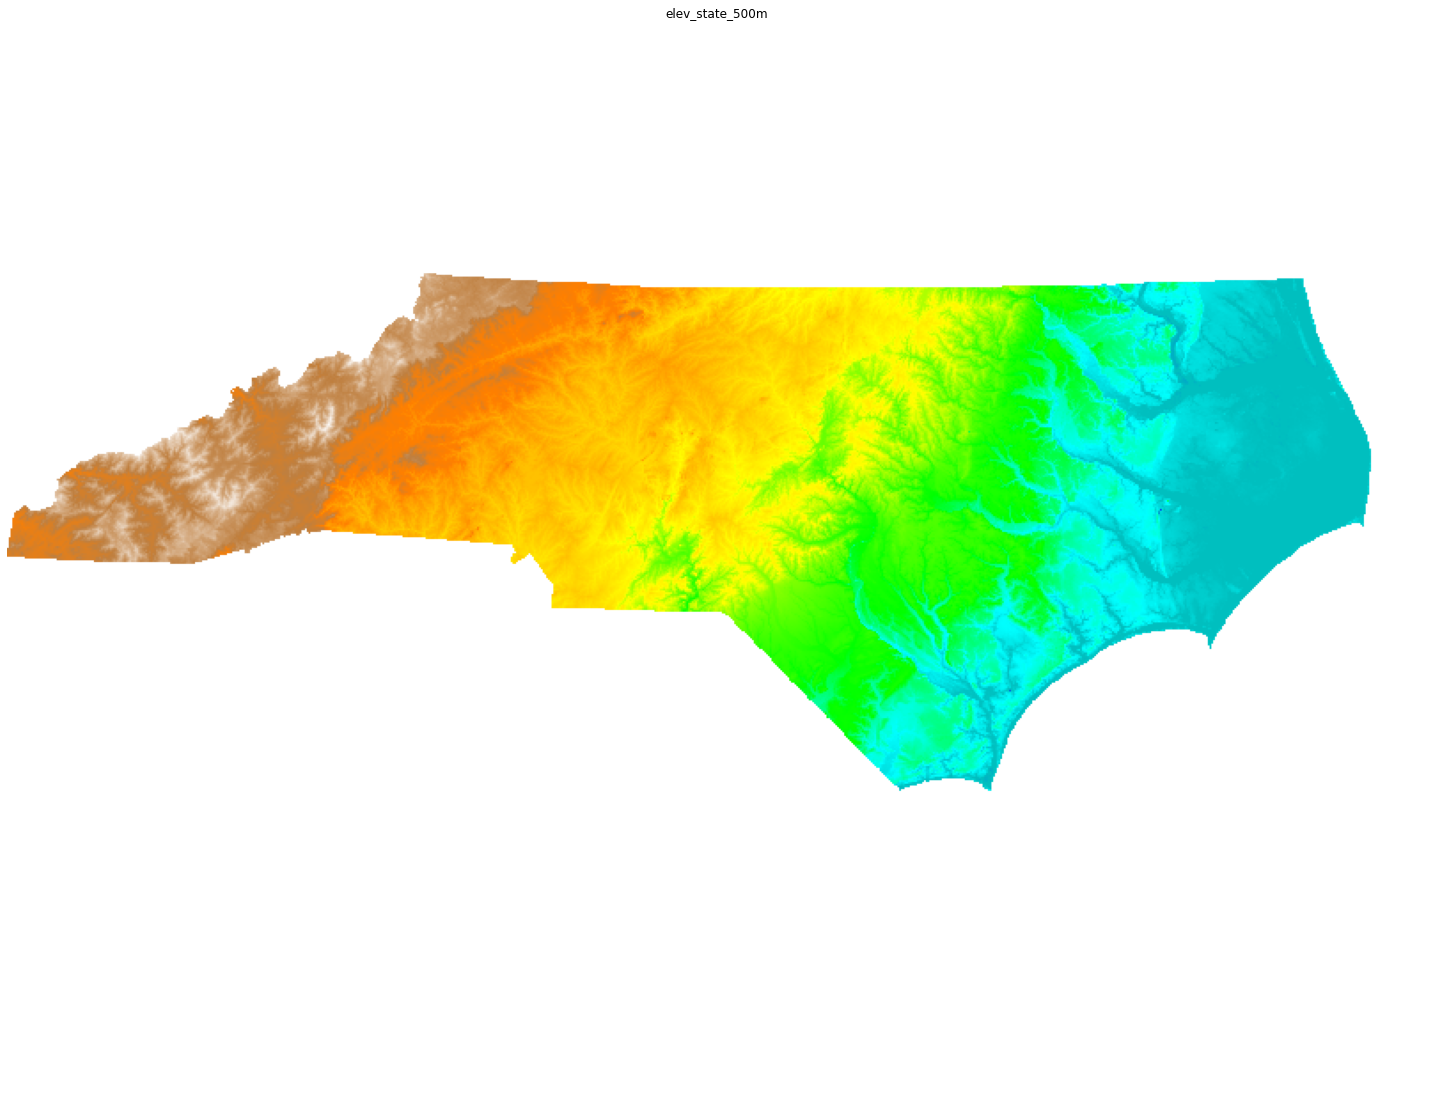

In [67]:
def show_rendered_map(map_name, map_type, LOCATION, mapset):
    
    import requests
    from pprint import pprint
    
    """Show a rendered map with the size of 800x600 pixel
    Args:
        map_name: The name of the raster map with optional mapset (name@mapset)
    """

    fig, ax = plt.subplots(figsize=(20, 18))
    
    if "@" in map_name:
        map_name, mapset = map_name.split("@")
    else:
        mapset = gs.read_command("g.mapset", "p").strip()

    print(f"Trying to render {map_type} map {map_name} of mapset {mapset}")
    url = f"{ACTINIA_URL}/locations/{LOCATION}/mapsets" \
        f"/{mapset}/{map_type}/{map_name}/render?width=800&height=600"
    print(url)
    r = requests.get(url, auth=ACTINIA_AUTH)
    if r.status_code != 200:
        pprint(r.text)
    else:
        from PIL import Image
        import io

        fp = io.BytesIO(r.content)
        image = Image.open(fp)
        imgplot = plt.imshow(image)
        ax.set_title(map_name)
        ax.set_axis_off()
        plt.tight_layout() 

show_rendered_map("elev_state_500m","raster_layers", LOCATION='nc_spm_08', mapset='PERMANENT')

Trying to render raster_layers map myslope of mapset test
http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/test/raster_layers/myslope/render?width=800&height=600


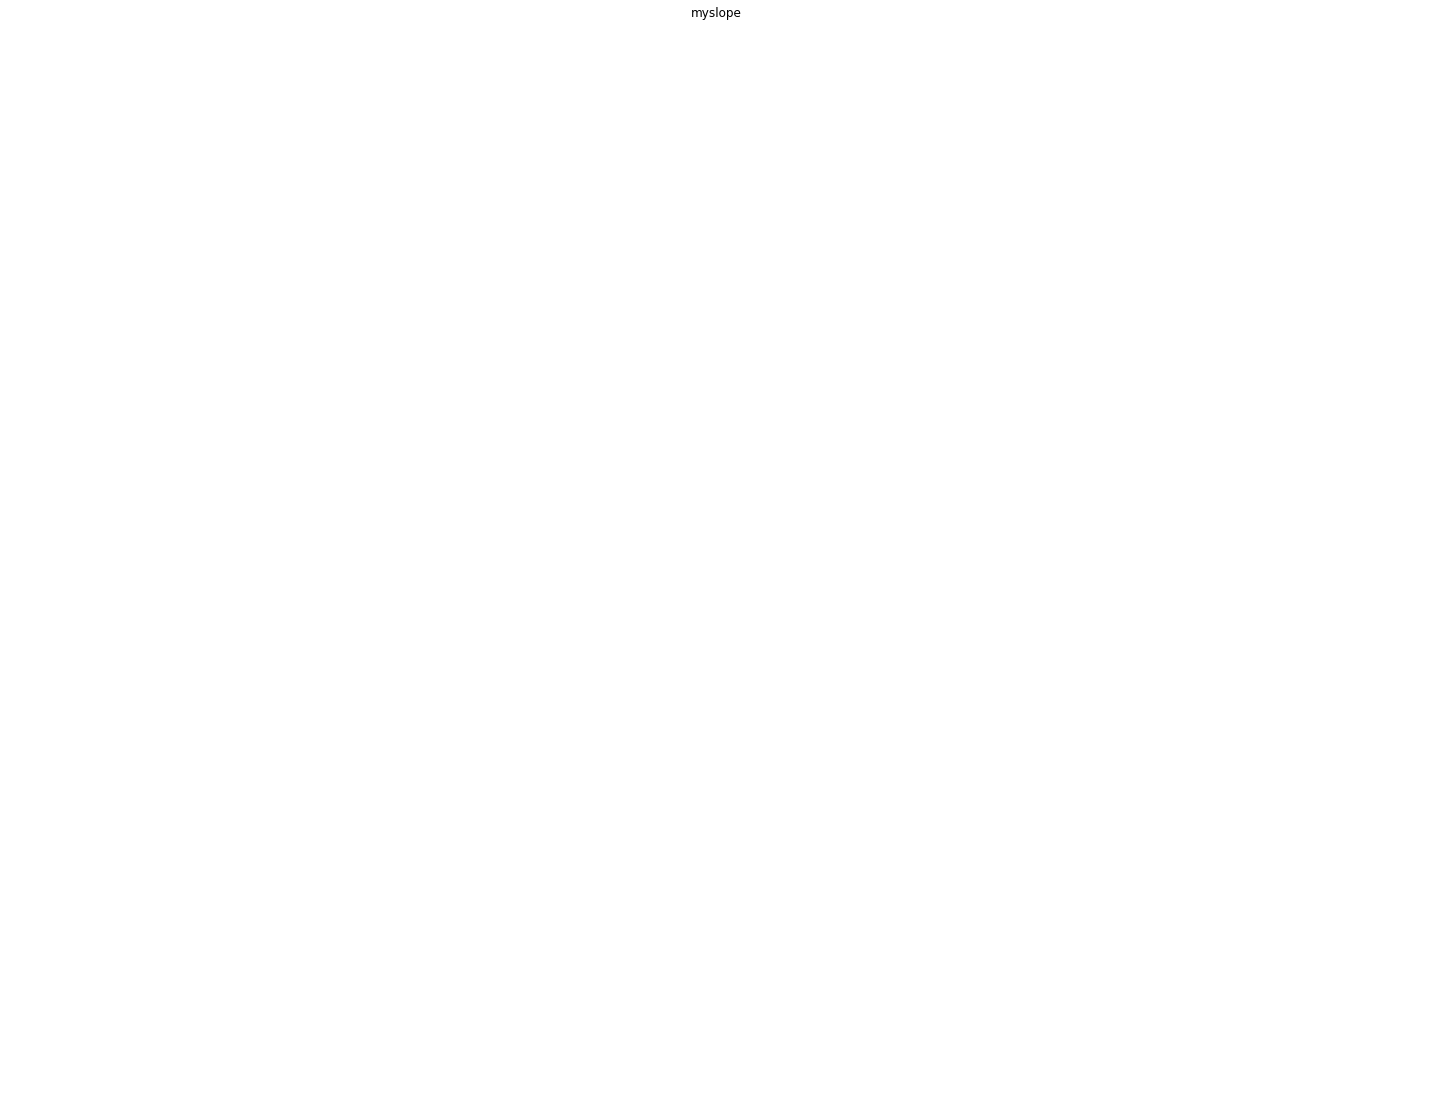

In [68]:
show_rendered_map("myslope@test","raster_layers", LOCATION='nc_spm_08', mapset='test')

In [69]:
show_rendered_map("elevation","raster_layers")

TypeError: show_rendered_map() missing 2 required positional arguments: 'LOCATION' and 'mapset'

In [ ]:
# def show_rendered_shaded_map(map_name, map_shade):
    
#     import requests
#     from pprint import pprint
    
#     """Show a rendered map with the size of 800x600 pixel
#     Args:
#         map_name: The name of the raster map with optional mapset (name@mapset)
#     """

#     fig, ax = plt.subplots(figsize=(20, 18))

#     ACTINIA_AUTH = ("actinia-gdi", "actinia-gdi")
#     LOCATION = 'nc_spm_08'
#     mapset = 'PERMANENT'
#     ACTINIA_VERSION = 'v3'
#     ACTINIA_URL = 'http://localhost:8088'
    
#     if "@" in map_name:
#         map_name, mapset = map_name.split("@")
#     else:
#         mapset = gs.read_command("g.mapset", "p").strip()

#     print(f"Trying to render {map_name} of mapset {mapset}")
#     url = f"{ACTINIA_URL}/api/{ACTINIA_VERSION}/locations/{LOCATION}/mapsets" \
#         f"/{mapset}/render_shade?shade={map_shade}?color=elevation"
        
#     #?color={map_name}?width=800.0&height=800.0"
#     print(url)
#     r = requests.get(url, auth=ACTINIA_AUTH)
#     if r.status_code != 200:
#         pprint(r.status_code)
#         pprint(r.text)
#     else:
#         from PIL import Image
#         import io

#         fp = io.BytesIO(r.content)
#         image = Image.open(fp)
#         imgplot = plt.imshow(image)
#         ax.set_title(map_name)

#         plt.tight_layout() 

# show_rendered_shaded_map('elevation','elevation_shade')

In [ ]:
help(gj.interact_display)

In [ ]:
!ace -d location="nc_spm_08" grass_command="g.extension -l" | jq

In [ ]:
!ace location="nc_spm_08" script="scripts/install_grass_plugins.sh" | jq

In [ ]:
# import subprocess
# import json
# result = subprocess.run(['ace','-d location="nc_spm_08" grass_command="r.info elevation"'], capture_output=True)
# print(result.stdout)

# result = json.loads(result.stdout)

# # gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
# , 
# print(result.stdout)
# p_chain = !ace -d location="nc_spm_08" grass_command="r.info elevation" | jq -r ".list" 
# print(p_chain)

In [ ]:
# p_chain = !ace -d location="nc_spm_08" grass_command="r.info elevation"
# def send_poll_commands(commands: List[List[str]], mapset: str = None) -> None:
#     """Create the actinia process chain, send it to the actinia server
#     and poll for the result
#     Args:
#         commands: A list of GRASS commands from the command line or from a script
#         mapset: If mapset is set, then the processing will be performed in the mapset of the persistent user database
#     """
#     for command in commands:
#         p_chain = create_actinia_process(command)
#         if p_chain:
#             PCHAIN["list"].append(p_chain)

#     if DRY_RUN is True:
#         print(simplejson.dumps(PCHAIN, sort_keys=False, indent=2 * ' '))
#         return

#     if mapset:
#         url = f"{ACTINIA_URL}/api/{ACTINIA_VERSION}/locations/{LOCATION}/" \
#             f"mapsets/{mapset}/processing_async"
#     else:
#         url = f"{ACTINIA_URL}/api/{ACTINIA_VERSION}/locations/{LOCATION}" \
#             "/processing_async_export"

#     print(url)
#     print(PCHAIN)
#     print(ACTINIA_USER)

#     req = requests.post(url, json=PCHAIN, auth=ACTINIA_AUTH)
#     if req.status_code not in [200, 201]:
#         msg = ''
#         try:
#             data = simplejson.loads(req.text)
#             if 'message' in data:
#                 msg = f": {data['message']}"
#         except Exception:
#             msg = req.text
#         grass.fatal(_(f"ERROR posting to url '{url}'{msg}"))
#     try:
#         data = simplejson.loads(req.text)
#     except Exception:
#         grass.fatal(_(req.text))
#         return

#     print("Resource status", data["status"])

#     poll_url = data["urls"]["status"]

#     print("Polling:", poll_url)

#     while True:
#         r = requests.get(poll_url, auth=ACTINIA_AUTH)

#         try:
#             data = simplejson.loads(r.text)
#             print("Resource poll status:", data["status"])
#             print(data["message"])

#             final_status = data["status"]
#             if data["status"] == "finished" or data["status"] == "error" or data["status"] == "terminated":
#                 break
#             time.sleep(1)
#         except Exception as a:
#             raise

#     print("--------------------------------------------------------------------------")

#     if r.status_code == 200:

#         if final_status == "terminated":
#             print(r.text)
#             return

#         for entry in data["process_log"]:
#             if entry["stdout"]:
#                 print(entry["stdout"])
#             if entry["stderr"][0]:
#                 pprint(entry["stderr"])
#         pprint(data["urls"])
#     else:
#         print(r.text)